In [19]:
import torch
from torch.distributions import MultivariateNormal, MixtureSameFamily, Categorical

In [61]:
means = torch.tensor([[-4, 4], [0,0], [4, 4]]).float()

m = MultivariateNormal(means, torch.stack([torch.eye(2)]*3))

In [62]:
mm = MixtureSameFamily(Categorical(torch.tensor([0.2]*3)), m)

In [63]:
samples = mm.sample(torch.tensor([1000]))

In [64]:
from matplotlib import pyplot as plt

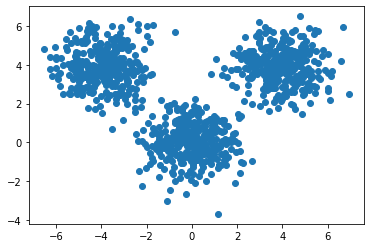

In [65]:
plt.scatter(samples[:, 0], samples[:, 1])

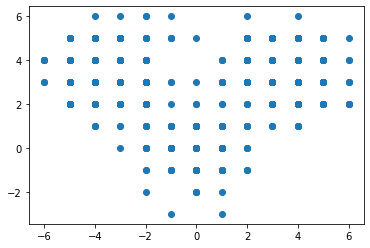

In [66]:
plt.scatter(samples.int()[:, 0], samples.int()[:, 1])

(array([[ 0.,  0.,  0.,  0.,  0.,  0.,  9., 16.,  6.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  7., 45., 54., 31., 10.],
        [ 0.,  0.,  0.,  0.,  2.,  9., 34., 50., 34.,  5.],
        [ 0.,  2.,  9., 21., 13.,  3.,  5.,  7.,  3.,  4.],
        [ 1.,  7., 23., 61., 47., 17.,  0.,  0.,  0.,  1.],
        [ 1.,  2., 24., 48., 37.,  4.,  0.,  4.,  0.,  0.],
        [ 0.,  1.,  5.,  8.,  5.,  3.,  8., 24., 16.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  9., 34., 64., 35.,  9.],
        [ 0.,  0.,  0.,  0.,  0.,  5., 33., 37., 26.,  7.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  5.,  5.,  2.,  1.]]),
 array([-6.52262688, -5.17759619, -3.8325655 , -2.48753481, -1.14250412,
         0.20252657,  1.54755726,  2.89258795,  4.23761864,  5.58264933,
         6.92768002]),
 array([-3.70032668, -2.67956111, -1.65879555, -0.63802998,  0.38273559,
         1.40350115,  2.42426672,  3.44503229,  4.46579785,  5.48656342,
         6.50732899]),
 <matplotlib.collections.QuadMesh at 0x7effd8f55c10>)

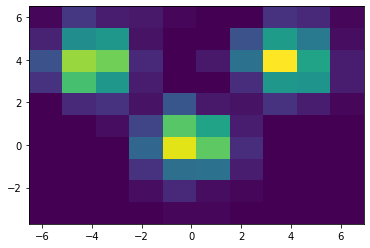

In [162]:
plt.hist2d(samples[:, 0].numpy(), samples[:, 1].numpy())

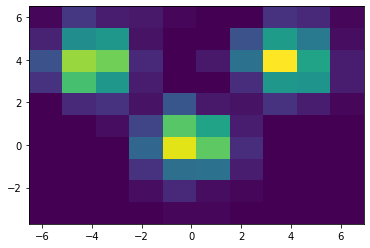

In [163]:
img, x_grid, y_grid, _ = plt.hist2d(samples[:, 0].numpy(), samples[:, 1].numpy())

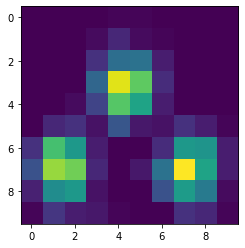

In [72]:
plt.imshow(img.transpose())

To implement the EM algorithm, we need the truncated normal distribution:

- Implementation of truncated multivariate distribution in R: tmvtnorm package
- This could be useful: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html


In [91]:
import rpy2
import numpy as np
from rpy2.robjects import numpy2ri
numpy2ri.activate()

In [74]:
from rpy2.robjects.packages import importr

In [99]:
import rpy2.robjects as robjects

In [75]:
tmv = importr("tmvtnorm")

In [104]:
strr = robjects.r('dim')

In [116]:
np2vec = robjects.r('as.vector')

In [310]:
xxx=robjects.r('list(a=5,b=matrix(c(7,8,27,99), nrow=1))')

In [311]:
xxx[0]

array([5.])

In [312]:
xxx[1]

array([[ 7.,  8., 27., 99.]])

In [120]:
np2vec

<rpy2.robjects.functions.SignatureTranslatedFunction object at 0x7effe0871300> [RTYPES.CLOSXP]
R classes: ('function',)

In [316]:
np2vec(means[0].numpy().astype(np.float64)

SyntaxError: unexpected EOF while parsing (2403992266.py, line 1)

In [121]:
x = robjects.r.rnorm(100)

In [123]:
x.r_repr

AttributeError: 'numpy.ndarray' object has no attribute 'r_repr'

In [478]:
mtmvnorm = robjects.r('function(m, l) tmvtnorm::mtmvnorm(as.vector(m), lower=as.vector(l), doComputeVariance=FALSE)$tmean')

In [479]:
mtmvnorm(means[0].numpy(), l=np.array([0.,0.]))

array([0.22560714, 4.00013383])

In [480]:
from importlib import reload
import trunc_mvnorm
reload(trunc_mvnorm)

<module 'trunc_mvnorm' from '/home/derek/meta_repo/bliss/case_studies/galaxy_identifiability/trunc_mvnorm.py'>

In [481]:
tm = trunc_mvnorm.TruncMVNorm()

In [482]:
tm.mtmvnorm(means[0].numpy(), None, np.array([[0.,0.], [-1., -1.]]), np.array([[1.,1.], [0., 0.]]))

(array([[ 0.21683078,  0.73954571],
        [-0.73954571, -0.21683078]]),
 array([[[ 3.82902873e-02, -2.21707097e-11],
         [-2.21707097e-11,  4.92777938e-02]],
 
        [[ 4.92777938e-02,  8.27427016e-12],
         [ 8.27427016e-12,  3.82902873e-02]]]))

In [483]:
tm.pmvnorm(means[0].numpy(), None, np.array([[0.,0.], [-1., -1.]]), np.array([[1.,1.], [0., 0.]]))

array([[4.13720077e-08],
       [4.13720077e-08]])

In [484]:
x_grid

array([-6.52262688, -5.17759619, -3.8325655 , -2.48753481, -1.14250412,
        0.20252657,  1.54755726,  2.89258795,  4.23761864,  5.58264933,
        6.92768002])

In [485]:
y_grid

array([-3.70032668, -2.67956111, -1.65879555, -0.63802998,  0.38273559,
        1.40350115,  2.42426672,  3.44503229,  4.46579785,  5.48656342,
        6.50732899])

In [486]:
from einops import rearrange, repeat, reduce

In [487]:
x_limits = repeat(np.stack([x_grid[:-1], x_grid[1:]], axis=1), "x p -> x 10 p")

In [488]:
y_limits = repeat(np.stack([y_grid[:-1], y_grid[1:]], axis=1), "y p -> 10 y p")

In [489]:
x_limits.shape

(10, 10, 2)

In [490]:
y_limits.shape

(10, 10, 2)

In [491]:
limits = np.concatenate([x_limits, y_limits], axis=2)

In [492]:
limits.shape

(10, 10, 4)

In [493]:
limits[0,0]

array([-6.52262688, -5.17759619, -3.70032668, -2.67956111])

In [494]:
limits_long = rearrange(limits, "X Y L -> (X Y) L")

In [495]:
res = tm.mtmvnorm(means[0].numpy(), None, limits_long[:, [0,2]], limits_long[:, [1,3]])
res_mean = rearrange(res[0], "(X Y) A -> X Y A", X=10, Y=10)
res_var = rearrange(res[1], "(X Y) A B -> X Y A B", X=10, Y=10)

In [496]:
res_mean.shape

(10, 10, 2)

In [497]:
limits[-1, -1]

array([5.58264933, 6.92768002, 5.48656342, 6.50732899])

In [498]:
res_mean[-1, -1]

array([5.68484525, 5.48656342])

In [499]:
res_var[-1, -1]

array([[1.02350072e-02, 1.78146562e+01],
       [1.78146562e+01, 1.00000000e+00]])

In [500]:
## Basic EM algorithm
from sklearn.cluster import KMeans

samples_pixel = samples.int() + 0.5
km = KMeans(n_clusters=3)
km.fit(samples_pixel)
km.cluster_centers_

array([[-2.99240122,  3.91337386],
       [ 3.95987654,  3.89506173],
       [ 0.47982709,  0.56051873]])

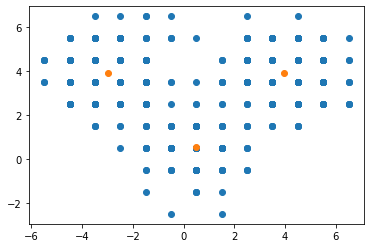

In [501]:
plt.scatter(samples_pixel[:, 0], samples_pixel[:, 1])
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1])

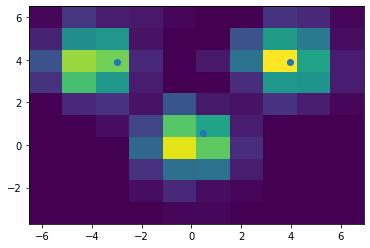

In [502]:
plt.hist2d(samples[:, 0].numpy(), samples[:, 1].numpy())
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1])

In [519]:
from tqdm import tqdm

In [520]:
def basic_em(grid, limits, mu_start, pi_start, n_iter):
    grid_long = rearrange(grid, "X Y -> (X Y)")
    limits_long = rearrange(limits, "X Y L -> (X Y) L")
    limits_lower_long = limits_long[:, [0,2]]
    limits_upper_long = limits_long[:, [1,3]]
    mu = np.copy(mu_start)
    pi = np.copy(pi_start)
    for _ in tqdm(range(n_iter)):
        ## E-step
        ## Calculate log-probability of each cluster
        probs_list = []
        for j in range(mu.shape[0]):
            ## Get expectation in each pixel
            #res = tm.mtmvnorm(mus[j], None, limits_long[:, [0,2]], limits_long[:, [1,3]])
            #res_mean = rearrange(res[0], "(X Y) A -> X Y A", X=10, Y=10)
            #res_var = rearrange(res[1], "(X Y) A B -> X Y A B", X=10, Y=10)
            ## Calculate the log-probability
            probs_j = tm.pmvnorm(mu[j], None, limits_lower_long, limits_upper_long)
            probs_list.append(probs_j)
        probs_long = np.stack(probs_list)
        #return(probs_long)
        #print(probs_long)
        probs = rearrange(probs_long, "K (X Y) 1 -> K X Y", X=10, Y=10)
        ## Multiply by the prior
        probs = rearrange(pi, "K -> K 1 1") * probs

        ## M-step
        prob_global = reduce((probs * grid), "K X Y -> K", "sum")
        pi = prob_global / prob_global.sum()
        
        for j in range(mu.shape[0]):
            probs_j = probs[j]
            #print(probs_j.shape)
            W = rearrange(probs_j * grid, "X Y -> X Y 1")
            
            res = tm.mtmvnorm(mu[j], None, limits_lower_long, limits_upper_long)
            res_mean = rearrange(res[0], "(X Y) A -> X Y A", X=10, Y=10)
            #return res[0]
            mu[j] = reduce(W * res_mean, "X Y A -> A", "sum")
            mu[j] = mu[j] / (probs_j * grid).sum()
    return mu, pi
            
        
            
            

In [ ]:
output = basic_em(img, limits, km.cluster_centers_, np.ones(3)/3, 100)

  0%|                                                          | 0/100 [00:00<?, ?it/s]

(10, 10)
(10, 10)
(10, 10)


  1%|▌                                                 | 1/100 [00:01<02:11,  1.33s/it]

(10, 10)
(10, 10)
(10, 10)


  2%|█                                                 | 2/100 [00:02<02:03,  1.26s/it]

(10, 10)
(10, 10)
(10, 10)


  3%|█▌                                                | 3/100 [00:03<01:42,  1.06s/it]

(10, 10)
(10, 10)
(10, 10)


  4%|██                                                | 4/100 [00:04<01:33,  1.03it/s]

(10, 10)
(10, 10)
(10, 10)


  5%|██▌                                               | 5/100 [00:05<01:27,  1.08it/s]

(10, 10)
(10, 10)
(10, 10)


  6%|███                                               | 6/100 [00:05<01:26,  1.08it/s]

(10, 10)
(10, 10)
(10, 10)


  7%|███▌                                              | 7/100 [00:06<01:22,  1.12it/s]

(10, 10)
(10, 10)
(10, 10)


  8%|████                                              | 8/100 [00:07<01:22,  1.11it/s]

(10, 10)
(10, 10)
(10, 10)


  9%|████▌                                             | 9/100 [00:08<01:21,  1.12it/s]

(10, 10)
(10, 10)
(10, 10)


 10%|████▉                                            | 10/100 [00:09<01:18,  1.15it/s]

(10, 10)
(10, 10)
(10, 10)


 11%|█████▍                                           | 11/100 [00:10<01:16,  1.17it/s]

(10, 10)
(10, 10)
(10, 10)


 12%|█████▉                                           | 12/100 [00:11<01:14,  1.19it/s]

(10, 10)
(10, 10)
(10, 10)


Exception ignored from cffi callback <function _processevents at 0x7effbd49e040>:
Traceback (most recent call last):
  File "/home/derek/.cache/pypoetry/virtualenvs/bliss-LacDF9_U-py3.9/lib/python3.9/site-packages/rpy2/rinterface_lib/callbacks.py", line 277, in _processevents
    try:
KeyboardInterrupt: 
 13%|██████▎                                          | 13/100 [00:11<01:15,  1.16it/s]

(10, 10)
(10, 10)
(10, 10)


 14%|██████▊                                          | 14/100 [00:12<01:14,  1.15it/s]

(10, 10)
(10, 10)
(10, 10)


 15%|███████▎                                         | 15/100 [00:14<01:22,  1.03it/s]

(10, 10)
(10, 10)
(10, 10)


 16%|███████▊                                         | 16/100 [00:14<01:20,  1.05it/s]

(10, 10)
(10, 10)
(10, 10)


 17%|████████▎                                        | 17/100 [00:15<01:16,  1.08it/s]

(10, 10)
(10, 10)
(10, 10)


 18%|████████▊                                        | 18/100 [00:16<01:17,  1.06it/s]

(10, 10)
(10, 10)
(10, 10)


 19%|█████████▎                                       | 19/100 [00:17<01:15,  1.08it/s]

(10, 10)
(10, 10)
(10, 10)


 20%|█████████▊                                       | 20/100 [00:18<01:15,  1.05it/s]

(10, 10)
(10, 10)
(10, 10)


 21%|██████████▎                                      | 21/100 [00:19<01:18,  1.01it/s]

(10, 10)
(10, 10)
(10, 10)


 22%|██████████▊                                      | 22/100 [00:20<01:18,  1.00s/it]

(10, 10)
(10, 10)
(10, 10)


 23%|███████████▎                                     | 23/100 [00:21<01:14,  1.03it/s]

(10, 10)
(10, 10)
(10, 10)


 24%|███████████▊                                     | 24/100 [00:22<01:12,  1.05it/s]

(10, 10)
(10, 10)
(10, 10)


 25%|████████████▎                                    | 25/100 [00:23<01:08,  1.10it/s]

(10, 10)
(10, 10)
(10, 10)


 26%|████████████▋                                    | 26/100 [00:24<01:06,  1.11it/s]

(10, 10)
(10, 10)
(10, 10)


 27%|█████████████▏                                   | 27/100 [00:25<01:05,  1.11it/s]

(10, 10)
(10, 10)
(10, 10)


 28%|█████████████▋                                   | 28/100 [00:26<01:07,  1.06it/s]

(10, 10)
(10, 10)
(10, 10)


 29%|██████████████▏                                  | 29/100 [00:27<01:06,  1.06it/s]

(10, 10)
(10, 10)
(10, 10)


 30%|██████████████▋                                  | 30/100 [00:28<01:05,  1.07it/s]

(10, 10)
(10, 10)


In [517]:
output

(array([[-3.94502941,  3.85251654],
        [ 3.85534773,  3.94651608],
        [-0.04734171,  0.13826557]]),
 array([0.29396924, 0.29206158, 0.41396918]))

In [518]:
np.ones(3)/3

array([0.33333333, 0.33333333, 0.33333333])

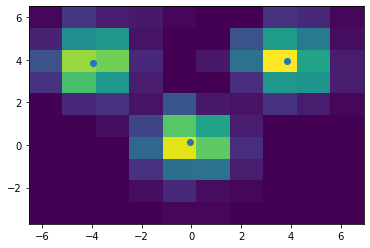

In [514]:
plt.hist2d(samples[:, 0].numpy(), samples[:, 1].numpy())
plt.scatter(output[0][:, 0], output[0][:, 1])